In [ ]:
# !pip install pandas==1.3.4
# !pip install numpy==1.21.2
# !pip install matplotlib==3.5.0
# !pip install scikit-learn==1.0.1
# !pip install tensorflow==2.4.1
# !pip install deap==1.3
# !pip install hyperopt==0.1.2
# !pip install torch==1.10.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

# DEAP

## Init

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import time
import operator
import math

from deap import base
from deap import creator
from deap import tools

from scipy.stats import randint,truncnorm,uniform

import multiprocessing

## Genetic Algorithm

In [4]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [5]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [7]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [8]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [9]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [11]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [12]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [13]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [14]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


In [15]:
# GA Parameters
NPOP = 50
NGEN = 15
CXPB = 0.5
MUTPB = 0.2

In [16]:
# fix the seed for reproducibility
# feel free to change it or comment out the line
random.seed(1)

# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Individual", list, fitness=creator.FitnessMax)

In [17]:
# Intialize toolbox
toolbox = base.Toolbox()

In [18]:
# Hyperparameters Definition
PARAM_NAMES = ["model__n_estimators","model__criterion",
               "model__class_weight","model__min_samples_split"]

# definition of an individual & a population
toolbox.register("model__n_estimators", randint.rvs, 5, 200)
toolbox.register("model__criterion", random.choice, ["gini", "entropy"])
toolbox.register("model__class_weight", random.choice, ["balanced","balanced_subsample"])
toolbox.register("model__min_samples_split", truncnorm.rvs, 0, 0.5, 0.005, 0.01)

# Define genes of individuals
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.model__n_estimators,
        toolbox.model__criterion,
        toolbox.model__class_weight,
        toolbox.model__min_samples_split,
    ),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [19]:
def mutPolynomialBoundedMix(individual, eta, low, up, is_int, indpb, discrete_params):
    
    for i in range(len(individual)):
        if discrete_params[i]:
            if random.random() < indpb:
                individual[i] = random.choice(discrete_params[i])
        else:
            individual[i] = tools.mutPolynomialBounded([individual[i]], 
                                                        eta[i], low[i], up[i], indpb)[0][0]
        
        if is_int[i]:
            individual[i] = int(individual[i])

    return individual,

In [20]:
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", mutPolynomialBoundedMix, 
                 eta = [0.1,None,None,0.1], 
                 low = [5,None,None,0], 
                 up = [200,None,None,1],
                 is_int = [True,False,False,False],
                 indpb=MUTPB,
                 discrete_params=[[],["gini", "entropy"],["balanced","balanced_subsample"],[]]
                )

In [21]:
def evaluate(individual):
    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}
    
    if strategy_params['model__min_samples_split'] > 1 or strategy_params['model__min_samples_split'] <= 0:
        return [-np.inf]
    
    tuned_pipe = clone(pipe).set_params(**strategy_params)

    return [np.mean(cross_val_score(tuned_pipe,X_train_full, y_train, 
                                  cv=5, scoring='f1',
                                  # n_jobs=-1,
                                  )
                     )]

# fitness function
toolbox.register("evaluate", evaluate)

In [22]:
# use parallel processing
pool = multiprocessing.Pool(16)
toolbox.register("map", pool.map)

In [23]:
mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

HALL OF FAME:
    0: [50, 'gini', 'balanced', 0.00016713543794360727], Fitness: 0.5630748100616518
    1: [69, 'entropy', 'balanced', 0.005165018060614889], Fitness: 0.5626539895920162
    2: [159, 'entropy', 'balanced_subsample', 0.005287641575458836], Fitness: 0.5612444342034152
HALL OF FAME:
    0: [37, 'entropy', 'balanced', 0.005165018060614889], Fitness: 0.5634679627435212
    1: [50, 'gini', 'balanced', 0.00016713543794360727], Fitness: 0.5630748100616518
    2: [69, 'entropy', 'balanced', 0.005165018060614889], Fitness: 0.5626539895920162
HALL OF FAME:
    0: [101, 'gini', 'balanced', 0.0046173403145286784], Fitness: 0.5649412614403753
    1: [50, 'entropy', 'balanced', 0.005165018060614889], Fitness: 0.5637688628957274
    2: [37, 'entropy', 'balanced', 0.005165018060614889], Fitness: 0.5634679627435212
HALL OF FAME:
    0: [50, 'entropy', 'balanced', 0.00016713543794360727], Fitness: 0.5721237141951832
    1: [37, 'entropy', 'balanced', 0.00016713543794360727], Fitness: 0.571

In [24]:
params = {}
for idx_hof, param_name in enumerate(PARAM_NAMES):
    params[param_name] = hall_of_fame[0][idx_hof]
    
params

{'model__n_estimators': 101,
 'model__criterion': 'entropy',
 'model__class_weight': 'balanced',
 'model__min_samples_split': 0.0007106340458649385}

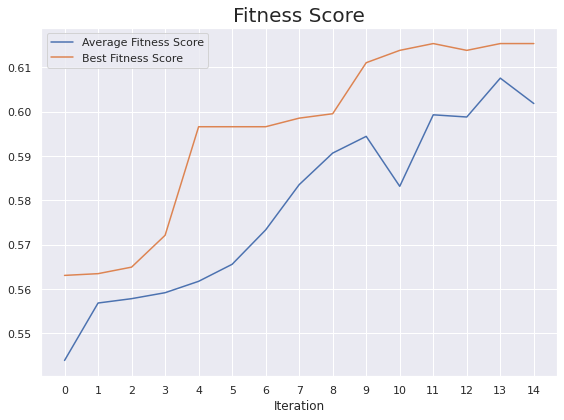

In [25]:
fig, ax = plt.subplots(sharex=True, figsize=(8, 6))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score",size=20)
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")
plt.tight_layout()
plt.show()

In [26]:
tuned_pipe = clone(pipe).set_params(**params)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.608187134502924


## Particle Swarm Optimization

In [27]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [28]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [29]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [30]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [31]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [32]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [34]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [35]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [36]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [37]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


In [38]:
# PSO Parameters
N = 50
w = 0.5
c1 = 0.3
c2 = 0.5
num_trials = 15

In [39]:
# fix the seed for reproducibility
# feel free to change it or comment out the line
random.seed(1)

# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Particle", list, fitness=creator.FitnessMax,
               speed=list, smin=list, smax=list, best=None)

/home/louisowen6/miniconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [40]:
# Intialize toolbox
toolbox = base.Toolbox()

In [41]:
# Hyperparameters Definition
PARAM_NAMES = ["model__n_estimators","model__criterion",
               "model__class_weight","model__min_samples_split"]

# definition of an individual & a population
toolbox.register("model__n_estimators", randint.rvs, 5, 200)
toolbox.register("model__criterion", random.choice, [0,1])
toolbox.register("model__class_weight", random.choice, [0,1])
toolbox.register("model__min_samples_split", truncnorm.rvs, 0, 0.5, 0.005, 0.01)

In [42]:
def generate(speed_bound):
    part = tools.initCycle(creator.Particle,
                           [toolbox.model__n_estimators,
                            toolbox.model__criterion,
                            toolbox.model__class_weight,
                            toolbox.model__min_samples_split,
                           ]
                          )
    part.speed = [random.uniform(speed_bound[i]['smin'], speed_bound[i]['smax']) for i in range(len(part))]
    part.smin = [speed_bound[i]['smin'] for i in range(len(part))]
    part.smax = [speed_bound[i]['smax'] for i in range(len(part))]
    return part


# Define genes of particles
toolbox.register("particle", generate, 
                 speed_bound=[{'smin': -2.5,'smax': 2.5},
                              {'smin': -1,'smax': 1},
                              {'smin': -1,'smax': 1},
                              {'smin': -0.001,'smax': 0.001}])
toolbox.register("population", tools.initRepeat, list, toolbox.particle)

In [43]:
def updateParticle(part, best, c1, c2, w, is_int):
    w = [w for _ in range(len(part))]
    u1 = (random.uniform(0, 1)*c1 for _ in range(len(part)))
    u2 = (random.uniform(0, 1)*c2 for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, map(operator.mul, w, part.speed), map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin[i]:
            part.speed[i] = math.copysign(part.smin[i], speed)
        elif abs(speed) > part.smax[i]:
            part.speed[i] = math.copysign(part.smax[i], speed)
    part[:] = list(map(operator.add, part, part.speed))
    
    for i, pos in enumerate(part):
        if is_int[i]:
            part[i] = int(pos)

# Update strategy
toolbox.register("update", updateParticle, c1=c1, c2=c2, w=w,
                is_int=[True,True,True,False]
                )

In [44]:
def evaluate(particle):
    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, particle)}
    strategy_params["model__criterion"] = "gini" if strategy_params["model__criterion"]==0 else "entropy"
    strategy_params["model__class_weight"] = "balanced" if strategy_params["model__class_weight"]==0 else "balanced_subsample"
    
    if strategy_params['model__min_samples_split'] > 1 or strategy_params['model__min_samples_split'] <= 0:
        return [-np.inf]
    
    tuned_pipe = clone(pipe).set_params(**strategy_params)

    return [np.mean(cross_val_score(tuned_pipe,X_train_full, y_train, 
                                  cv=5, scoring='f1',
                                  # n_jobs=-1,
                                  )
                     )]

# fitness function
toolbox.register("evaluate", evaluate)

In [45]:
# use parallel processing
pool = multiprocessing.Pool(16)
toolbox.register("map", pool.map)

In [46]:
pop = toolbox.population(n=N)
mean_arr = np.zeros(num_trials)
best_arr = np.zeros(num_trials)
hall_of_fame = tools.HallOfFame(maxsize=3)

best = None
for g in range(num_trials):
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for part, fit in zip(pop, fitnesses):
        part.fitness.values = fit
        
        if not part.best or part.fitness.values > part.best.fitness.values:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values
        if not best or part.fitness.values > best.fitness.values:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values
    for part in pop:
        toolbox.update(part, best)
        
    hall_of_fame.update(pop)
    print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )
    
    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean_arr[g] = np.mean(fitnesses)
    best_arr[g] = np.max(fitnesses)

HALL OF FAME:
    0: [121, 1, 0, 0.005619500683203336], Fitness: 0.5628845621159831
    1: [186, 1, 0, 0.00533012918107986], Fitness: 0.5619211920868749
    2: [82, 0, 0, 0.005079700005193703], Fitness: 0.5613394162122021
HALL OF FAME:
    0: [127, 1, 0, 0.0045968790714956504], Fitness: 0.5661543056256575
    1: [121, 1, 0, 0.005619500683203336], Fitness: 0.5628845621159831
    2: [84, 0, 0, 0.004810306588745517], Fitness: 0.5626400244792442
HALL OF FAME:
    0: [127, 1, 0, 0.0045968790714956504], Fitness: 0.5661543056256575
    1: [127, 1, 0, 0.004542621873018485], Fitness: 0.5638111660936532
    2: [186, 0, 0, 0.004652821867083171], Fitness: 0.5629747808615247
HALL OF FAME:
    0: [127, 1, 0, 0.0045968790714956504], Fitness: 0.5661543056256575
    1: [110, 1, 0, 0.004456056879951871], Fitness: 0.5651443878072117
    2: [127, 1, 0, 0.004761936269970986], Fitness: 0.565037760531258
HALL OF FAME:
    0: [111, 1, 0, 0.004318643882560094], Fitness: 0.5677512797974636
    1: [127, 1, 0, 0.

In [47]:
params = {}
for idx_hof, param_name in enumerate(PARAM_NAMES):
    if param_name == "model__criterion":
        params[param_name] = "gini" if hall_of_fame[0][idx_hof]==0 else "entropy"
    elif param_name == "model__class_weight":
        params[param_name] = "balanced" if hall_of_fame[0][idx_hof]==0 else "balanced_subsample"
    else:
        params[param_name] = hall_of_fame[0][idx_hof]
    
params

{'model__n_estimators': 75,
 'model__criterion': 'entropy',
 'model__class_weight': 'balanced',
 'model__min_samples_split': 0.0037241038302412493}

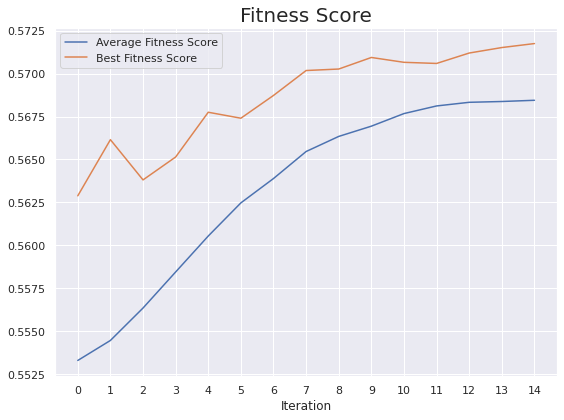

In [48]:
fig, ax = plt.subplots(sharex=True, figsize=(8, 6))

sns.lineplot(x=range(num_trials), y=mean_arr, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(num_trials), y=best_arr, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score",size=20)
ax.set_xticks(range(num_trials))
ax.set_xlabel("Iteration")
plt.tight_layout()
plt.show()

In [49]:
tuned_pipe = clone(pipe).set_params(**params)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5691747572815534


# NNI

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from nni.experiment import Experiment

In [2]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [3]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [5]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [6]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [7]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [9]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [10]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [11]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define hyperparameter space

In [12]:
hyperparameter_space = { 
    'model__n_estimators': {'_type': 'randint', '_value': [5, 200]}, 
    'model__criterion': {'_type': 'choice', '_value': ['gini', 'entropy']}, 
    'model__class_weight': {'_type': 'choice', '_value': ["balanced","balanced_subsample"]}, 
    'model__min_samples_split': {'_type': 'uniform', '_value': [0, 0.1]}, 
}  

In [13]:
hyperparameter_space_numeric = { 
    'model__n_estimators': {'_type': 'randint', '_value': [5, 200]}, 
    'model__criterion': {'_type': 'choice', '_value': [0, 1]}, 
    'model__class_weight': {'_type': 'choice', '_value': [0, 1]}, 
    'model__min_samples_split': {'_type': 'uniform', '_value': [0, 0.1]}, 
}  

In [14]:
hyperparameter_space_advisor = { 
    'model__criterion': {'_type': 'choice', '_value': ['gini', 'entropy']}, 
    'model__class_weight': {'_type': 'choice', '_value': ["balanced","balanced_subsample"]}, 
    'model__min_samples_split': {'_type': 'uniform', '_value': [0, 0.1]}, 
}  

## Grid Search

In [15]:
best_parameters = {
    "model__n_estimators": 27,
    "model__criterion": "entropy",
    "model__class_weight": "balanced_subsample",
    "model__min_samples_split": 0.05
}

In [16]:
tuned_pipe = clone(pipe).set_params(**best_parameters)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5167674546454096


## Random Search

In [17]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_random_search'
experiment.config.tuner.name = 'Random'
experiment.config.tuner.class_args['seed'] = 0

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model.py'" #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [18]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 09:24:35] Creating experiment, Experiment ID: 01ovlyth
[2022-05-30 09:24:35] Starting web server...
[2022-05-30 09:24:36] Setting up...
[2022-05-30 09:24:36] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [19]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
print(best_trial.value, best_trial.parameter)

0.599735399016607 {'model__n_estimators': 194, 'model__criterion': 'entropy', 'model__class_weight': 'balanced_subsample', 'model__min_samples_split': 0.0014706304965369289}


In [20]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5973333333333333


In [21]:
experiment.stop()

[2022-05-30 09:29:50] Stopping experiment, please wait...
[2022-05-30 09:29:52] Experiment stopped


## TPE

In [22]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_tpe'
experiment.config.tuner.name = 'TPE'
experiment.config.tuner.class_args = {
                                    'optimize_mode': 'maximize',
                                    'seed': 0
                                    }

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [23]:
experiment.run(8080, wait_completion = True, debug = True)

[2022-05-30 09:29:56] Creating experiment, Experiment ID: qg5knida
[2022-05-30 09:29:56] Starting web server...
[2022-05-30 09:29:56] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:29:57] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:29:57] (urllib3.connectionpool) http://localhost:8080 "GET /api/v1/nni/check-status HTTP/1.1" 200 36
[2022-05-30 09:29:57] Setting up...
[2022-05-30 09:29:57] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:29:57] (urllib3.connectionpool) http://localhost:8080 "POST /api/v1/nni/experiment HTTP/1.1" 200 28
[2022-05-30 09:29:57] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080
[2022-05-30 09:30:07] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:30:07] (urllib3.connectionpool) http://localhost:8080 "GET /api/v1/nni/check-status HTTP/1.1" 200 32
[2022-05-30 09:30:17] (urllib3.con

True

In [24]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
print(best_trial.value, best_trial.parameter)

[2022-05-30 09:35:00] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:35:00] (urllib3.connectionpool) http://localhost:8080 "GET /api/v1/nni/export-data HTTP/1.1" 200 20881
0.6181739315974903 {'model__n_estimators': 195, 'model__criterion': 'entropy', 'model__class_weight': 'balanced_subsample', 'model__min_samples_split': 0.0006636374717157983}


In [25]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6181015452538632


In [26]:
experiment.stop()

[2022-05-30 09:35:09] Stopping experiment, please wait...
[2022-05-30 09:35:09] (urllib3.connectionpool) Starting new HTTP connection (1): localhost:8080
[2022-05-30 09:35:11] (urllib3.connectionpool) http://localhost:8080 "DELETE /api/v1/nni/experiment HTTP/1.1" 200 0
[2022-05-30 09:35:11] Experiment stopped


## SMAC

In [27]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_smac'
experiment.config.tuner.name = 'SMAC'
experiment.config.tuner.class_args['optimize_mode'] = 'maximize'

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [28]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 09:35:16] Creating experiment, Experiment ID: e62t13qn
[2022-05-30 09:35:16] Starting web server...
[2022-05-30 09:35:17] Setting up...
[2022-05-30 09:35:17] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [29]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
print(best_trial.value, best_trial.parameter)

0.6192037487561184 {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.0005502416428725066, 'model__n_estimators': 199}


In [30]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6193353474320242


In [31]:
experiment.stop()

[2022-05-30 09:40:52] Stopping experiment, please wait...
[2022-05-30 09:40:56] Experiment stopped


## BOGP

In [32]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_bogp'
experiment.config.tuner.name = 'GPTuner'
experiment.config.tuner.class_args['optimize_mode'] = 'maximize'
experiment.config.tuner.class_args['utility'] = 'ei'
experiment.config.tuner.class_args['xi'] = 0.01

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model_numeric.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space_numeric
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [33]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 09:40:59] Creating experiment, Experiment ID: 2ki731hl
[2022-05-30 09:40:59] Starting web server...
[2022-05-30 09:41:00] Setting up...
[2022-05-30 09:41:00] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [34]:
non_numeric_mapping = params = {
        'model__criterion': ['gini','entropy'],
        'model__class_weight': ['balanced','balanced_subsample'],
    }

best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
for key in non_numeric_mapping:
    best_trial.parameter[key] = non_numeric_mapping[key][best_trial.parameter[key]]
print(best_trial.value, best_trial.parameter)

0.6196713736297277 {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.00055461211818435, 'model__n_estimators': 159}


In [35]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6191198786039454


In [36]:
experiment.stop()

[2022-05-30 09:49:42] Stopping experiment, please wait...
[2022-05-30 09:49:45] Experiment stopped


## Metis

In [37]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_metis'
experiment.config.tuner.name = 'MetisTuner'
experiment.config.tuner.class_args['optimize_mode'] = 'maximize'

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model_numeric.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space_numeric
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [38]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 09:49:48] Creating experiment, Experiment ID: gn8q5uow
[2022-05-30 09:49:48] Starting web server...
[2022-05-30 09:49:49] Setting up...
[2022-05-30 09:49:49] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [39]:
non_numeric_mapping = params = {
        'model__criterion': ['gini','entropy'],
        'model__class_weight': ['balanced','balanced_subsample'],
    }

best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
for key in non_numeric_mapping:
    best_trial.parameter[key] = non_numeric_mapping[key][best_trial.parameter[key]]
print(best_trial.value, best_trial.parameter)

0.5908728486859774 {'model__n_estimators': 122, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'model__min_samples_split': 0.00173059072806428}


In [40]:
experiment.stop()

[2022-05-30 11:04:23] Stopping experiment, please wait...
[2022-05-30 11:04:26] Experiment stopped


## Simulated Annealing

In [41]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_anneal'
experiment.config.tuner.name = 'Anneal'
experiment.config.tuner.class_args['optimize_mode'] = 'maximize'

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [42]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 11:04:28] Creating experiment, Experiment ID: 4i56hn1s
[2022-05-30 11:04:28] Starting web server...
[2022-05-30 11:04:29] Setting up...
[2022-05-30 11:04:29] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [43]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
print(best_trial.value, best_trial.parameter)

0.6024803485704895 {'model__n_estimators': 103, 'model__criterion': 'gini', 'model__class_weight': 'balanced_subsample', 'model__min_samples_split': 0.0010101249953063539}


In [44]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5997229916897507


In [45]:
experiment.stop()

[2022-05-30 11:09:15] Stopping experiment, please wait...
[2022-05-30 11:09:18] Experiment stopped


## Hyper Band

In [46]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_hyper_band'
experiment.config.advisor.name = 'Hyperband'
experiment.config.advisor.class_args['optimize_mode'] = 'maximize'
experiment.config.advisor.class_args['R'] = 200
experiment.config.advisor.class_args['eta'] = 3
experiment.config.advisor.class_args['exec_mode'] = 'parallelism'

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model_advisor.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space_advisor
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [47]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 11:09:21] Creating experiment, Experiment ID: blv1f3tc
[2022-05-30 11:09:21] Starting web server...
[2022-05-30 11:09:22] Setting up...
[2022-05-30 11:09:22] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [48]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]

best_trial.parameter['model__n_estimators'] = best_trial.parameter['TRIAL_BUDGET'] * 50
del best_trial.parameter['TRIAL_BUDGET']

print(best_trial.value, best_trial.parameter)

0.591493989049198 {'model__criterion': 'gini', 'model__class_weight': 'balanced_subsample', 'model__min_samples_split': 0.001676130360763284, 'model__n_estimators': 100}


In [49]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5931758530183727


In [50]:
experiment.stop()

[2022-05-30 11:16:13] Stopping experiment, please wait...
[2022-05-30 11:16:17] Experiment stopped


## BOHB

In [51]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_bohb'
experiment.config.advisor.name = 'BOHB'
experiment.config.advisor.class_args['optimize_mode'] = 'maximize'
experiment.config.advisor.class_args['max_budget'] = 200
experiment.config.advisor.class_args['min_budget'] = 5
experiment.config.advisor.class_args['eta'] = 3

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model_advisor.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space_advisor
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [52]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-05-30 11:16:19] Creating experiment, Experiment ID: 4yjndxc2
[2022-05-30 11:16:19] Starting web server...
[2022-05-30 11:16:20] Setting up...
[2022-05-30 11:16:20] Web portal URLs: http://127.0.0.1:8080 http://172.19.71.163:8080


True

In [53]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]

best_trial.parameter['model__n_estimators'] = best_trial.parameter['TRIAL_BUDGET'] * 50
del best_trial.parameter['TRIAL_BUDGET']

print(best_trial.value, best_trial.parameter)

0.6166438293663608 {'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.000396569883631686, 'model__n_estimators': 1100}


In [54]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6173228346456693


In [55]:
experiment.stop()

[2022-05-30 12:30:42] Stopping experiment, please wait...
[2022-05-30 12:30:46] Experiment stopped
